In [1]:
import sys, os
sys.path.append("./EntryGuidance")

from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat
import pickle
from time import time

import numpy as np
import chaospy as cp 
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 
from EntryGuidance.Triggers import AltitudeTrigger
from EntryGuidance.VMC import VMC, velocity_trigger
from EntryGuidance.EntryVehicle import ConstantAeroEV
from Utils import Unscented 

np.set_printoptions(suppress=True, precision=3)

In [18]:
mdir = "E:\Documents\GitHub\Research\Matlab\iLQR"
fname = "RobustTestSolution.mat"
# fname = "FixedGainTestSolution.mat"

data = loadmat(os.path.join(mdir,fname))

In [45]:
P0 = 1*np.diag([2500, 0.25*np.pi/180, 5000])**2  # h s fpa (no velocity term) 

N = 2000
x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

# X0, mw, cw = Unscented.Transform(x0, P0, k=4)
# X0 = X0.T

mass = 7200.

print(X0.shape)
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
print(X0.shape)

data.keys()


(3, 2000)
(5, 2000)


dict_keys(['__header__', '__version__', '__globals__', 'u', 'v', 'mean', 'var', 'h', 'fpa', 's', 'weights', 'cost', 'bounds', 'X0', 'ddp', 'sigma_weights', 'L', 'D', 'Dm', 'Dv', 'stats', 'ut'])

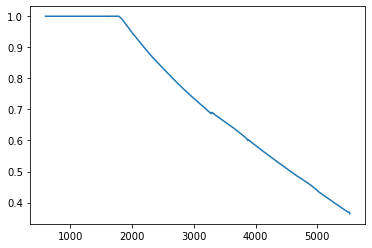

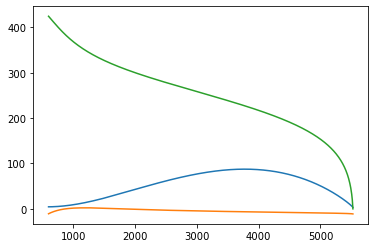

In [46]:
def smooth_sat(x, tuning=20):
    """Another saturation function, from 
    Saturated Robust Adaptive Control for Uncertain Nonlinear Systems using a new approximate model
    
    """
    q = 2*x-1
    return 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))

class ddp_controller:

    def __init__(self, data):
        v = data['v'].squeeze()
        u0 = data['u'][0] # feedfoward term 
        u0[-1] = u0[-2]
        u0 = np.append(u0, u0[-2])
        
        if data['u'].shape[0] < 4:
            kd = 0.1
            ks = -0.1
            kf = -50.0
            K = lambda v: np.array([kd, ks, kf])
            print("Fixed Gain Controller")
        else:
            K = interp1d(v[:-1], data['u'][1:], bounds_error=False, fill_value=(data['u'][1:,-2], data['u'][1:,0]))
            
        self.K = K
        self.u = interp1d(v, u0, bounds_error=False, fill_value=(u0[-1],u0[0]))
        xr = np.vstack([data['Dm'], data['mean'][1:]])
        self.ref = interp1d(v, xr, bounds_error=False, fill_value=(xr[:,-1],xr[:,0]))
        

    def __call__(self, E, x, L, D):
        # compute error states, apply gains
        r,s,v,fpa,_ = x
        
        xr = self.ref(v)
        eD = D - xr[0]
        es = s/1000 - xr[2]
        ef = fpa - xr[1]
        K = self.K(v)
        if 0:
            print(K)
#             print(eD, es, np.degrees(ef))
#             print(xr)
        u = smooth_sat(self.u(v) + K[0]*eD + K[1]*es + K[2]*ef)
        u = np.clip(u, 0, 1)
#         u = np.clip(self.u(v) + K[0]*eD + K[1]*es + K[2]*ef, 0, 1)
        
#         u[np.isnan(u)] = 1
        
        return u
    
C = ddp_controller(data)
v = data['v'].squeeze()    
xr = C.ref(v)
xr[1] = np.degrees(xr[1])

plt.figure()
plt.plot(v, C.u(v))
# plt.plot(v, C.K(v)[0:2].T)

plt.figure()
plt.plot(v, xr.T)

plt.show()    

In [47]:
mc = VMC()
mc.null_sample(N)
# mc.null_sample(7) # for unscented transform comparison only

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.46, 0.35, CD=CD, CL=CL)

 
Generating 2000 samples...


In [60]:
# mc._run(X0, stepsize=0.25, Ef=150000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})
# mc._run(X0, stepsize=[5, 0.1, 1], Ef=150000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

mean = np.mean(mc.xf, axis=0)
std = np.std(mc.xf, axis=0)
std_ut = data['ut'][0][0][-1][0] # mean alt, low alt, 3*dr

print("Low Altitude\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(mean[0]/1000-3396.2-3*std[0]/1000, std_ut[1]))
print("3-sigma DR\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(3*std[1]/1000, std_ut[2]))

Low Altitude
	MC: 6.242 km
	UT: 6.212 km
3-sigma DR
	MC: 0.995 km
	UT: 0.190 km


Low Altitude = 6.242 km, UT = 6.212 km
3sigma DR = 0.995 km, UT = 0.190 km


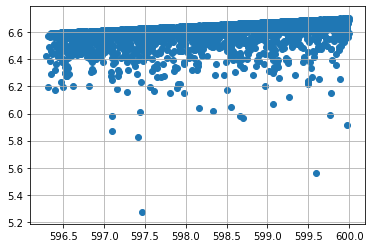

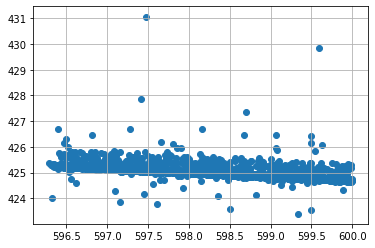

In [55]:



mc.xf.shape  # N x n 

if 0: # Set X0 to unscented above to debug 
    vu = data['ut'][0][0][0]
    xu = data['ut'][0][0][1].T # 
    uu = data['ut'][0][0][2].T

    k = 7

    plt.figure(666, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[0]/1000-3396.2)

    plt.plot(vu, xu[:k].T/1000, 'k--')   

    plt.grid(1)
    plt.figure(669, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[1]/1000)

    plt.plot(vu, xu[2*k:3*k].T, 'k--')   

    plt.grid(1)
    plt.figure(668, figsize=(10,10))
    for traj, control in zip(mc.mc, mc.mcu):
        plt.plot(traj.T[2], control)

    plt.plot(vu, uu, 'k--')   
    plt.grid(1)

#     plt.figure(667, figsize=(10,10))
#     for traj, aero in zip(mc.mc, mc.mca):
#         plt.plot(traj.T[2], aero)

#     # plt.plot(vu, xu[:k].T/1000, 'k--')   
#     plt.plot(v, xr[0].T, 'k')
#     plt.grid(1)

xf = mc.xf.T
plt.figure()
plt.scatter(xf[2], xf[0]/1000-3396.2)
plt.grid(1)

plt.figure()
plt.scatter(xf[2], xf[1]/1000)
plt.grid(1)